In [2]:
from intake import open_catalog
import datetime
import numpy as np
import pandas as pd
import scipy.io
from scipy import interpolate
import gsw
import gcsfs
import xarray as xr
import rclv
import os
from copy import deepcopy
from skimage import measure
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# load ssh eddy information
df = pd.read_pickle('eddy_data.pkl')
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.0,45.0,4.944328e+10,0.083280,-0.650595,-0.000009,80266.753659,-0.087273,0.035749,-1.0,0.357019,0.050497,123.875,20.125
1,2.0,31.0,1.041958e+10,0.009457,0.230652,0.000003,65940.386649,-0.050919,-0.041515,1.0,0.101414,0.003837,115.875,11.125
2,3.0,48.0,4.940120e+09,0.009673,0.165413,0.000006,52602.179429,-0.019697,-0.006703,1.0,0.145094,0.006766,113.375,11.625
3,4.0,50.0,2.289068e+10,0.020630,-0.200860,-0.000004,85517.729432,-0.044308,-0.019305,-1.0,0.173021,0.010500,114.375,10.375
4,5.0,43.0,1.113819e+10,0.023152,0.269953,0.000005,59882.550288,-0.161588,-0.052377,1.0,0.151511,0.008405,118.125,20.125


In [4]:
dura = df.loc[:, 1].values
rad = df.loc[:, 6].values

amp = df.loc[:, 3].values
damp = df.loc[:, 4].values

cyc = df.loc[:, 9].values
vort = df.loc[:, 5].values

spx = df.loc[:, 7].values
spy = df.loc[:, 8].values

edsp = df.loc[:, 10].values
ke = df.loc[:, 10].values

lon = df.loc[:, 12].values
lat = df.loc[:, 13].values

In [5]:
leak_data = np.zeros((2394, 22))
leak_data[:, :] = np.NaN
intru_data = np.zeros((2394, 22))
intru_data[:, :] = np.NaN

leak_norm = np.zeros((2394, 30))
leak_norm[:, :] = np.NaN
intru_norm = np.zeros((2394, 30))
intru_norm[:, :] = np.NaN

leak_array = np.zeros((2394, 1))
leak_array[:] = np.NaN

In [6]:
df_leak = pd.DataFrame(leak_data)
df_intru = pd.DataFrame(intru_data)

df_leak_norm = pd.DataFrame(leak_norm)
df_intru_norm = pd.DataFrame(intru_norm)

In [7]:
cal_var = np.load('cal_var.npy')
eddy_norm_t = np.linspace(0, 1, 30)

for i in np.arange(2394):
    fn1 = './pkl/leak_data_' + str(i).zfill(4) + '.pkl'
    fn2 = './pkl/intru_data_' + str(i).zfill(4) + '.pkl'
    if os.path.exists(fn1):
        df_tmp1 = pd.read_pickle(fn1)
        df_tmp2 = pd.read_pickle(fn2)
        df_leak.iloc[i, :] = df_tmp1.iloc[0]
        df_intru.iloc[i, :] = df_tmp2.iloc[0]
        
        idtmp = int(cal_var[i, 2]) + 4
        
        var1 = (df_tmp1.iloc[0, 3:idtmp] / df_tmp1.iloc[0, 3]).to_numpy()
        var_t1 = (cal_var[i, 0] - cal_var[i, 1]) / cal_var[i, 0]
        var_t2 = (cal_var[i, 0] - cal_var[i, 1] + cal_var[i, 2] * 10) / cal_var[i, 0]
        var_tt = np.linspace(var_t1, var_t2, var1.shape[0])
        
        if var_tt.shape[0] > 1:
            fun1 = interpolate.interp1d(var_tt, var1, bounds_error=False)
            df_leak_norm.loc[i, :] = fun1(eddy_norm_t);
            
            tmp = df_leak_norm.loc[i, :].values
            tmp = tmp[~np.isnan(tmp)]
            
            if tmp.shape[0] > 1:
                leak_array[i] = tmp[-1]
        #var2 = cal
        #time_var1 = cal_var[i]

In [8]:
#total num 
eddyid = np.where((lon<125) & (leak_array[:,0]>0))[0]
eddyid.shape

(1605,)

In [9]:
# num of anticyc
eddyid1 = np.where((lon<125) & (leak_array[:,0]>0) & (cyc>0))[0]
eddyid1.shape

(862,)

In [10]:
# num of cyc
eddyid2 = np.where((lon<125) & (leak_array[:,0]>0) & (cyc<0))[0]
eddyid2.shape

(743,)

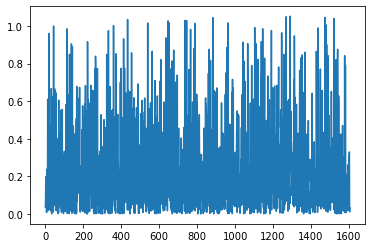

In [106]:
plt.plot(leak_array[eddyid])

In [221]:
dura_new = dura[eddyid]
rad_new = rad[eddyid]

amp_new = amp[eddyid]
damp_new = damp[eddyid]

cyc_new = cyc[eddyid]
vort_new = vort[eddyid]

spx_new = spx[eddyid]
spy_new = spy[eddyid]

edsp_new = edsp[eddyid]
ke_new = ke[eddyid]

lon_new = lon[eddyid]
lat_new = lat[eddyid]

leak_array_new = leak_array[eddyid]
leak_array_new[leak_array_new>1] = 1
#leak_array_new = [tmp[0] for tmp in leak_array_new.tolist()]

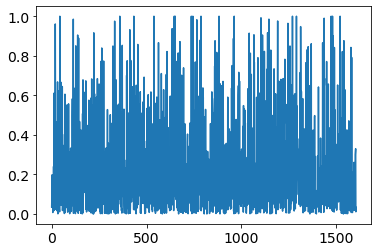

In [138]:
plt.plot(leak_array_new)

In [39]:
plt.rcParams.update({'font.size': 14
    , 'legend.markerscale': 1., 'axes.titlesize': 14, 'axes.labelsize' : 14,
      'legend.fontsize' : 10,'legend.handlelength': 2})

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

### leakiness with amp

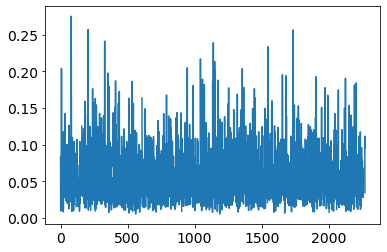

In [139]:
plt.plot(amp)

In [147]:
biny = np.arange(0.025, 0.251, 0.025)

amp_bin = np.zeros((eddyid.shape[0],))
for i in np.arange(amp_new.shape[0]):
    index = np.abs(biny - amp_new[i]).argmin()
    amp_bin[i] = biny[index]
    
data_leak_amp = [leak_array_new[amp_bin==bin_num].flatten().tolist() for bin_num in biny]


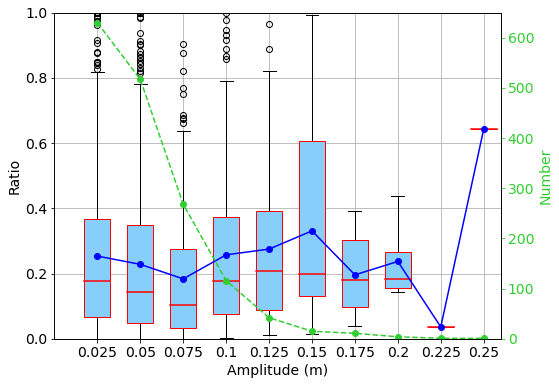

In [148]:
medianprops = dict(linestyle='-', linewidth=1.5, color='red')
capprops = dict(linewidth=1, color='k')
boxprops = dict(facecolor='lightskyblue', edgecolor='red')

fig = plt.figure(figsize=(8, 6))
ax1 = plt.subplot(111)
plt.boxplot(data_leak_amp, positions=biny, showfliers=True, widths=0.015, patch_artist=True, medianprops=medianprops, boxprops=boxprops, capprops=capprops);

plt.plot(biny, [np.mean(tmp) for tmp in data_leak_amp], color='b', marker='o', zorder=30)

plt.xlim(0, 0.26)
plt.ylim(0, 1)
plt.ylabel('Ratio')
plt.xlabel('Amplitude (m)')
labels = [round(tmp, 3) for tmp in biny]
plt.xticks(ticks=biny, labels=labels)

plt.grid()

ax2 = ax1.twinx()
ax2.plot(biny, [len(tmp) for tmp in data_leak_amp], color='limegreen', marker='o', linestyle='--')
ax2.set_ylabel('Number', color='limegreen')
ax2.set_ylim(0, 650)
plt.tick_params(axis='y', colors='limegreen')


### leakiness with duration

In [143]:
biny = np.arange(30, 301, 30)

dura_bin = np.zeros((eddyid.shape[0],))
for i in np.arange(dura_new.shape[0]):
    index = np.abs(biny - dura_new[i]).argmin()
    dura_bin[i] = biny[index]
    
data_leak_dura = [leak_array_new[dura_bin==bin_num].flatten().tolist() for bin_num in biny]

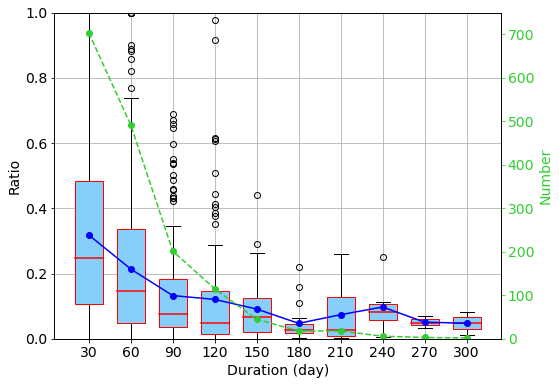

In [146]:
medianprops = dict(linestyle='-', linewidth=1.5, color='red')
capprops = dict(linewidth=1, color='k')
boxprops = dict(facecolor='lightskyblue', edgecolor='red')

fig = plt.figure(figsize=(8, 6))
ax1 = plt.subplot(111)
plt.boxplot(data_leak_dura, positions=biny, showfliers=True, widths=20, patch_artist=True, medianprops=medianprops, boxprops=boxprops, capprops=capprops);

plt.plot(biny, [np.mean(tmp) for tmp in data_leak_dura], color='b', marker='o', zorder=30)

#plt.xlim(-1.5e-5, 1.5e-5)
plt.ylim(0, 1)
plt.ylabel('Ratio')
plt.xlabel('Duration (day)')
#labels = [round(tmp, 3) for tmp in biny]
plt.xticks(ticks=biny)

plt.grid()

ax2 = ax1.twinx()
ax2.plot(biny, [len(tmp) for tmp in data_leak_dura], color='limegreen', marker='o', linestyle='--')
ax2.set_ylabel('Number', color='limegreen')
ax2.set_ylim(0, 750)
plt.tick_params(axis='y', colors='limegreen')


### Leakiness with vort

In [187]:
biny = np.arange(-1.5e-5, 1.5001e-5, 3e-6)

vort_bin = np.zeros((eddyid.shape[0],))
for i in np.arange(vort_new.shape[0]):
    index = np.abs(biny - vort_new[i]).argmin()
    vort_bin[i] = biny[index]
    
data_leak_vort = [leak_array_new[vort_bin==bin_num].flatten().tolist() for bin_num in biny]

/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


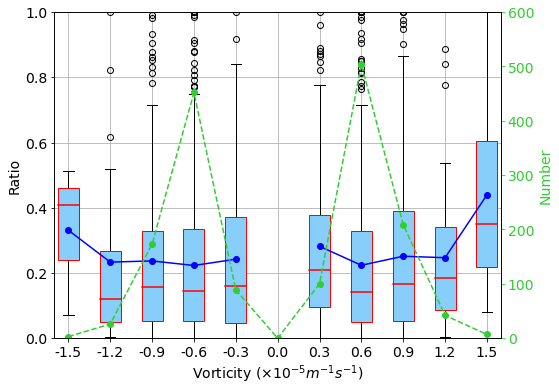

In [188]:
medianprops = dict(linestyle='-', linewidth=1.5, color='red')
capprops = dict(linewidth=1, color='k')
boxprops = dict(facecolor='lightskyblue', edgecolor='red')

fig = plt.figure(figsize=(8, 6))
ax1 = plt.subplot(111)
plt.boxplot(data_leak_vort, positions=biny, showfliers=True, widths=1.5e-6, patch_artist=True, medianprops=medianprops, boxprops=boxprops, capprops=capprops);

plt.plot(biny, [np.mean(tmp) for tmp in data_leak_vort], color='b', marker='o', zorder=30)

plt.xlim(-1.6e-5, 1.6e-5)
plt.ylim(0, 1)
plt.ylabel('Ratio')
plt.xlabel(r'Vorticity ($\times 10^{-5} m^{-1} s^{-1}$)')
labels = [round(tmp, 2) for tmp in np.arange(-1.5, 1.5001, 0.3)]
plt.xticks(ticks=biny, labels=labels)

plt.grid()

ax2 = ax1.twinx()
ax2.plot(biny, [len(tmp) for tmp in data_leak_vort], color='limegreen', marker='o', linestyle='--')
ax2.set_ylabel('Number', color='limegreen')
ax2.set_ylim(0, 600)
plt.tick_params(axis='y', colors='limegreen')

### Leakiness with u/c

In [172]:
sp = np.sqrt(spx_new**2 + spy_new**2)
para = edsp_new / sp

<ipython-input-172-0ab0e9405af3>:2: RuntimeWarning: divide by zero encountered in true_divide
  para = edsp_new / sp


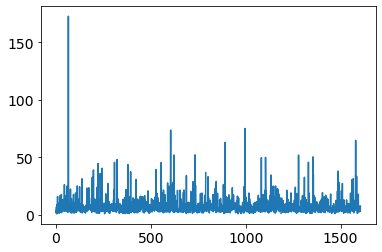

In [173]:
plt.plot(para)

In [184]:
biny = np.arange(1, 21, 2)

para_bin = np.zeros((eddyid.shape[0],))
for i in np.arange(para.shape[0]):
    index = np.abs(biny - para[i]).argmin()
    para_bin[i] = biny[index]
    
data_leak_para = [leak_array_new[para_bin==bin_num].flatten().tolist() for bin_num in biny]

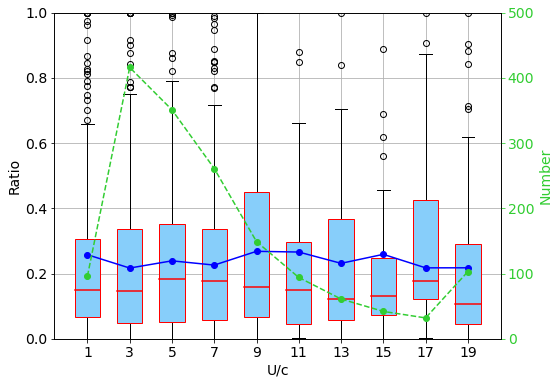

In [186]:
medianprops = dict(linestyle='-', linewidth=1.5, color='red')
capprops = dict(linewidth=1, color='k')
boxprops = dict(facecolor='lightskyblue', edgecolor='red')

fig = plt.figure(figsize=(8, 6))
ax1 = plt.subplot(111)
plt.boxplot(data_leak_vort, positions=biny, showfliers=True, widths=1.2, patch_artist=True, medianprops=medianprops, boxprops=boxprops, capprops=capprops);

plt.plot(biny, [np.mean(tmp) for tmp in data_leak_para], color='b', marker='o', zorder=30)

#plt.xlim(-1.6e-5, 1.6e-5)
plt.ylim(0, 1)
plt.ylabel('Ratio')
plt.xlabel('U/c')
#labels = [round(tmp, 2) for tmp in np.arange(-1.5, 1.5001, 0.3)]
#plt.xticks(ticks=biny, labels=labels)

plt.grid()

ax2 = ax1.twinx()
ax2.plot(biny, [len(tmp) for tmp in data_leak_para], color='limegreen', marker='o', linestyle='--')
ax2.set_ylabel('Number', color='limegreen')
ax2.set_ylim(0, 500)
plt.tick_params(axis='y', colors='limegreen')

### Leakiness with damp

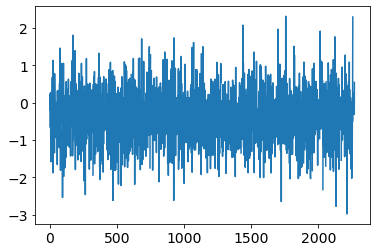

In [189]:
plt.plot(damp)

In [202]:
biny = np.arange(-2, 2.01, 0.4)

damp_bin = np.zeros((eddyid.shape[0],))
for i in np.arange(damp_new.shape[0]):
    index = np.abs(biny - damp_new[i]).argmin()
    damp_bin[i] = biny[index]
    
data_leak_damp = [leak_array_new[damp_bin==bin_num].flatten().tolist() for bin_num in biny]


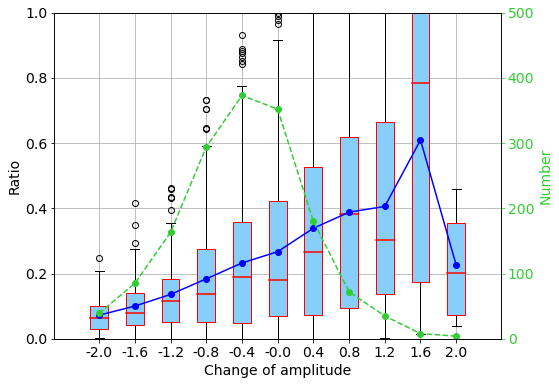

In [212]:
medianprops = dict(linestyle='-', linewidth=1.5, color='red')
capprops = dict(linewidth=1, color='k')
boxprops = dict(facecolor='lightskyblue', edgecolor='red')

fig = plt.figure(figsize=(8, 6))
ax1 = plt.subplot(111)
plt.boxplot(data_leak_damp, positions=biny, showfliers=True, widths=0.2, patch_artist=True, medianprops=medianprops, boxprops=boxprops, capprops=capprops);

plt.plot(biny, [np.mean(tmp) for tmp in data_leak_damp], color='b', marker='o', zorder=30)

#plt.xlim(0, 0.26)
plt.ylim(0, 1.0)
plt.ylabel('Ratio')
plt.xlabel('Change of amplitude')
labels = [round(tmp, 3) for tmp in biny]
plt.xticks(ticks=biny, labels=labels)

plt.grid()

ax2 = ax1.twinx()
ax2.plot(biny, [len(tmp) for tmp in data_leak_damp], color='limegreen', marker='o', linestyle='--')
ax2.set_ylabel('Number', color='limegreen')
ax2.set_ylim(0, 500)
plt.tick_params(axis='y', colors='limegreen')


### Leakiness with ke

In [219]:
biny = np.arange(0, 0.51, 0.05)

ke_bin = np.zeros((eddyid.shape[0],))
for i in np.arange(ke_new.shape[0]):
    index = np.abs(biny - ke_new[i]).argmin()
    ke_bin[i] = biny[index]
    
data_leak_ke = [leak_array_new[ke_bin==bin_num].flatten().tolist() for bin_num in biny]

/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


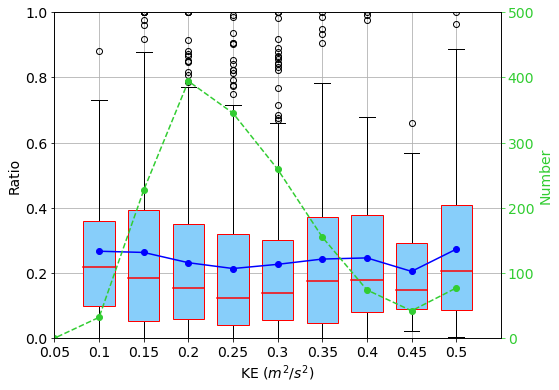

In [227]:
medianprops = dict(linestyle='-', linewidth=1.5, color='red')
capprops = dict(linewidth=1, color='k')
boxprops = dict(facecolor='lightskyblue', edgecolor='red')

fig = plt.figure(figsize=(8, 6))
ax1 = plt.subplot(111)
plt.boxplot(data_leak_ke, positions=biny, showfliers=True, widths=0.035, patch_artist=True, medianprops=medianprops, boxprops=boxprops, capprops=capprops);

plt.plot(biny, [np.mean(tmp) for tmp in data_leak_ke], color='b', marker='o', zorder=30)

plt.ylim(0, 1.0)
plt.ylabel('Ratio')
plt.xlabel(r'KE ($m^2/s^2$)')
labels = [round(tmp, 3) for tmp in biny]
plt.xticks(ticks=biny, labels=labels)
plt.xlim(0.05, 0.55)

plt.grid()

ax2 = ax1.twinx()
ax2.plot(biny, [len(tmp) for tmp in data_leak_ke], color='limegreen', marker='o', linestyle='--')
ax2.set_ylabel('Number', color='limegreen')
ax2.set_ylim(0, 500)
plt.tick_params(axis='y', colors='limegreen')


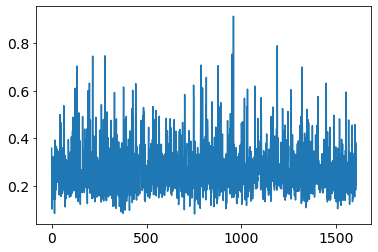

In [213]:
plt.plot(ke_new)